In [1]:
import tensorflow as tf

print(tf.__version__)

from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import tensorflow_addons as tfa
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import pickle

from object_detection import get_bounding_box, plot_results, plot_bounding_box, iou, get_json_fname, get_iou_metrics, accuracy, plot_bounding_box_i

HEIGHT, WIDTH = (640, 960)

2.7.0


In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
model = YOLOv4(
    input_shape=(HEIGHT, WIDTH, 3),
    anchors=YOLOV4_ANCHORS,
    num_classes=80,
    training=False,
    yolo_max_boxes=100,
    yolo_iou_threshold=0.5,
    yolo_score_threshold=0.5,
)

model.load_weights("./yolov4.h5")

## Run Inference on all images on a class

In [4]:
json_root_dir = Path('/Users/deepakduggirala/Documents/Elephants-dataset')

In [6]:
class_1000 = Path('/Users/deepakduggirala/Documents/Elephants-dataset-png/1000')
class_1000.exists()

True

In [5]:
def run_inference(class_dir, json_root_dir, score_thresh=0.5, iou_thresh=0.4):
    tfds = image_dataset_from_directory(str(class_dir), labels=None, 
                             image_size=(HEIGHT, WIDTH),
                             batch_size=1,
                             shuffle=False).map(tf.keras.layers.Rescaling(1/255.0))
    boxes, scores, classes, valid_detections = model.predict(tfds)
    
    elp_detected_indices = np.where(classes==20) #COCO dataset class for elephant - 20
    elp_detected_thresh_indices = elp_detected_indices[0][scores[elp_detected_indices] > score_thresh]
    
    img_fnames = sorted(class_dir.iterdir())
    N = len(img_fnames)
    
    metrics = get_iou_metrics(elp_detected_thresh_indices, img_fnames, classes, boxes, json_root_dir)
    acc = accuracy(metrics, N, iou_thresh)
    
    inference_data = {'boxes': boxes,
                    'scores': scores,
                    'classes': classes,
                    'valid_detections': valid_detections,
                    'metrics': metrics,
                    'accuracy': acc}
    return inference_data, tfds

In [11]:
inference_data, tfds = run_inference(class_1000, json_root_dir)

Found 44 files belonging to 1 classes.


In [25]:
with open(class_1000 / 'inference_simple_resize.pickle', 'wb') as f:
    pickle.dump(inference_data, f)

/Users/deepakduggirala/Documents/Elephants-dataset/1000/IMG_1732.json


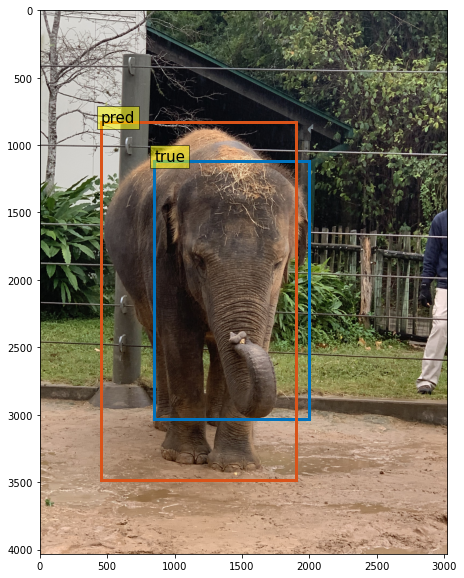

In [20]:
img_fnames = sorted(class_1000.iterdir())
plot_bounding_box_i(21, img_fnames, inference_data['classes'], inference_data['boxes'], json_root_dir)

In [9]:
for c in Path('/Users/deepakduggirala/Documents/Elephants-dataset-png').iterdir():
    if c.is_dir() :
        inference_dump = c / 'inference_simple_resize.pickle'
        if not inference_dump.exists():
            print('start', c.name)
            inference_data, tfds = run_inference(c, json_root_dir)
            print(c.name, inference_data['accuracy'])
            with open(inference_dump, 'wb') as f:
                pickle.dump(inference_data, f)

start 1040
Found 49 files belonging to 1 classes.
1040 0.7551020408163265
start 1015
Found 122 files belonging to 1 classes.
1015 0.9918032786885246
start 1012
Found 98 files belonging to 1 classes.
1012 0.8979591836734694
